# Dependencies

In [ ]:
# This file was written to be run in Google Colab.
# If this file is run elsewhere, the code below can be deleted.

from google.colab import drive
drive.mount('/content/drive')
import sys
# foldername should be modified to where the file is stored.
foldername = '/WandB/week_3/'
sys.path.append(f'/content/drive/My Drive/{foldername}')
%cd /content/drive/My\ Drive/$foldername

Mounted at /content/drive
/content/drive/My Drive/WandB/assignment_3


In [ ]:
!pip3 install wandb transformers[sentencepiece] datasets evaluate 
!pip install ml_collections
import wandb, transformers, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

from datasets import load_from_disk, load_dataset, Dataset, load_metric
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

import evaluate
from transformers.trainer_callback import (EarlyStoppingCallback, 
                                           TrainerCallback)
import params
from huggingface_hub import notebook_login


from sklearn.model_selection import GroupShuffleSplit
import os
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Data Analysis

In [ ]:
run=wandb.init(project="mlops-course-assgn3",job_type='Analysis_V3')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
artifact = run.use_artifact('dmeltzer/mlops-course-assgn3/model-mv0ofc09:v0', type='model')
artifact_dir = artifact.download()

wandb:   7 of 7 files downloaded.  


In [ ]:
from params import default_cfg as cfg

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    artifact_dir,
    num_labels=cfg.NUM_CLASSES)

tokenizer=AutoTokenizer.from_pretrained(
    artifact_dir
)

model.push_to_hub(cfg.HUB_MODEL_ID)
tokenizer.push_to_hub(cfg.HUB_MODEL_ID)

pytorch_model.bin:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/dhmeltzer/bert-tiny-goodreads-wandb/commit/aadf98166e1119e0851e4e61a52d7bbd9d90f1a7', commit_message='Upload tokenizer', commit_description='', oid='aadf98166e1119e0851e4e61a52d7bbd9d90f1a7', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
test_artifact = run.use_artifact(f"{cfg.TEST_DATA_ARTIFACT}:latest")
test_artifact.download(root=cfg.TEST_DATA_FOLDER)
test_dataset=load_from_disk(cfg.TEST_DATA_FOLDER)

valid_dataset = run.use_artifact(f"{cfg.VALID_DATA_ARTIFACT}:latest")
valid_dataset.download(root=cfg.VALID_DATA_FOLDER)
valid_dataset = load_from_disk(cfg.VALID_DATA_FOLDER)

train_dataset = run.use_artifact(f"{cfg.TRAIN_DATA_ARTIFACT}:latest")
train_dataset.download(root=cfg.TRAIN_DATA_FOLDER)
train_dataset = load_from_disk(cfg.TRAIN_DATA_FOLDER)

drop_cols=[col for col in list(test_dataset.features) if col not in ['input_ids','attention_mask','rating']]

test_dataset=test_dataset.remove_columns(drop_cols)
valid_dataset=valid_dataset.remove_columns(drop_cols)
train_dataset=train_dataset.remove_columns(drop_cols)

test_dataset=test_dataset.rename_column('rating','labels')
valid_dataset=valid_dataset.rename_column('rating','labels')
train_dataset=train_dataset.rename_column('rating','labels')

test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
valid_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])


wandb: Downloading large artifact goodreads_test_data:latest, 142.39MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.5
wandb: Downloading large artifact goodreads_valid_data:latest, 142.07MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:2.3
wandb: Downloading large artifact goodreads_train_data:latest, 424.69MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:14.2


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    collate_fn=data_collator
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=32,
    collate_fn=data_collator
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    collate_fn=data_collator
)

In [ ]:
model.to(device)
model.eval()
metric = evaluate.load("accuracy")

valid_predictions=torch.tensor([]).to(device)
valid_labels=torch.tensor([]).to(device)

for batch in valid_dataloader:
    batch={k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        outputs=model(**batch)
    logits=outputs.logits
    predictions=torch.argmax(logits,dim=-1)
    metric.add_batch(predictions=predictions,references=batch['labels'])

    valid_predictions=torch.cat((valid_predictions,predictions))
    valid_labels=torch.cat((valid_labels,batch['labels']))

validation_acc=metric.compute()
wandb.log(validation_acc)
validation_acc

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'accuracy': 0.5305294495359291}

In [ ]:
model.to(device)
model.eval()
metric = evaluate.load("accuracy")

test_predictions=torch.tensor([]).to(device)
test_labels=torch.tensor([]).to(device)

for batch in test_dataloader:
    batch={k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        outputs=model(**batch)
    logits=outputs.logits
    predictions=torch.argmax(logits,dim=-1)
    metric.add_batch(predictions=predictions,references=batch['labels'])

    test_predictions=torch.cat((test_predictions,predictions))
    test_labels=torch.cat((test_labels,batch['labels']))

test_acc=metric.compute()
wandb.log(test_acc)
test_acc

{'accuracy': 0.5323818696553133}

In [ ]:
model.to(device)
model.eval()
metric = evaluate.load("accuracy")

train_predictions=torch.tensor([]).to(device)
train_labels=torch.tensor([]).to(device)

for batch in train_dataloader:
    batch={k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        outputs=model(**batch)
    logits=outputs.logits
    predictions=torch.argmax(logits,dim=-1)
    metric.add_batch(predictions=predictions,references=batch['labels'])

    train_predictions=torch.cat((train_predictions,predictions))
    train_labels=torch.cat((train_labels,batch['labels']))

train_acc=metric.compute()
wandb.log(train_acc)
train_acc

{'accuracy': 0.6087248387441991}

In [ ]:
wandb.log({'train_accuracy':train_acc['accuracy']})
wandb.log({'valid_accuracy':validation_acc['accuracy']})
wandb.log({'test_accuracy':test_acc['accuracy']})

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

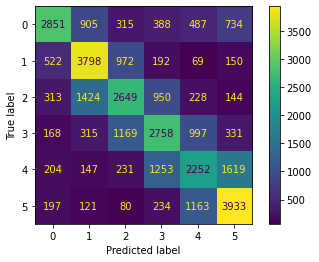

In [ ]:
cm_test=confusion_matrix(test_labels.cpu().numpy(),test_predictions.cpu().numpy())
cm_display_test = ConfusionMatrixDisplay(cm_test).plot()
cm_display_test.figure_.savefig('conf_mat_test.png',dpi=300)
wandb.log({"test_cm": wandb.Image("conf_mat_test.png")})

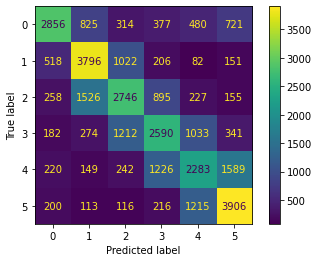

In [ ]:
cm_valid=confusion_matrix(valid_labels.cpu().numpy(),valid_predictions.cpu().numpy())
cm_display_valid = ConfusionMatrixDisplay(cm_valid).plot()
cm_display_valid.figure_.savefig('conf_mat_valid.png',dpi=300)
wandb.log({"valid_cm": wandb.Image("conf_mat_valid.png")})


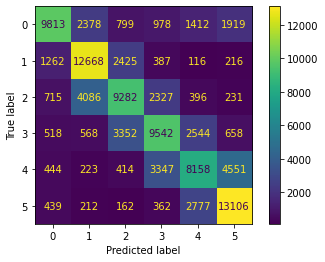

In [ ]:
cm_train=confusion_matrix(train_labels.cpu().numpy(),train_predictions.cpu().numpy())
cm_display_train = ConfusionMatrixDisplay(cm_train)
cm_display_train.plot()
cm_display_train.figure_.savefig('conf_mat_train.png',dpi=300)
wandb.log({"train_cm": wandb.Image("conf_mat_train.png")})

In [ ]:
stack=[]
for i, (pred,label) in enumerate(zip(valid_predictions.cpu().numpy(),valid_labels.cpu().numpy())):
    if pred==5 and label==0:
        stack.append(i)

max_confused=pd.DataFrame({'review_text':[],'label':[]})
for i in stack:
    label=valid_dataset[i]["labels"]
    text=tokenizer.decode(valid_dataset[i]["input_ids"],skip_special_tokens=True)
    print(f'label is {label}')
    print(f'Text:\n-----\n{text}')
    print('\n')
    max_confused.loc[len(max_confused.index)]=[text,label.item()]

In [ ]:
wandb.log({'valid labels are off':wandb.Table(dataframe=max_confused)})

In [ ]:
stack_test=[]
for i, (pred,label) in enumerate(zip(test_predictions.cpu().numpy(),test_labels.cpu().numpy())):
    if pred==5 and label==0:
        stack_test.append(i)

max_confused_test=pd.DataFrame({'review_text':[],'label':[]})
for i in stack_test:
    label=test_dataset[i]["labels"]
    text=tokenizer.decode(test_dataset[i]["input_ids"],skip_special_tokens=True)
    print(f'label is {label}')
    print(f'Text:\n-----\n{text}')
    print('\n')
    max_confused_test.loc[len(max_confused_test.index)]=[text,label.item()]

label is 0
Text:
-----
markus zusak made a post about how he enjoyed this book... must check it out now!


label is 0
Text:
-----
just finished this second book, i agree that this is the best one so far.. i loved all the details and background information on the characters, i liked that there were so many more adventures and some of the characters from the first book continued to be part of this story. penryn continues to be the hero that she has been so far and i love that she is not a martyr.. on to the next one..


label is 0
Text:
-----
so much love for this book so much love for garrett and hannah i honestly cried reading this they're so cute rtc!!


label is 0
Text:
-----
i so cannot believe i waited this long to read divergent! thanks to faye at http : / / fayeflamereviews. blogspot. com for telling me that i absolutely had to read this book next! i could not put it down and stayed up into the wee hours of the morning to finish it! what an amazing dystopian ya novel with fabulou

In [ ]:
wandb.log({'test labels are off':wandb.Table(dataframe=max_confused_test)})

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_scores=f1_score(test_predictions.cpu().numpy(),
         test_labels.cpu().numpy(),
         average=None,
         labels=np.arange(6))
f1_scores_with_labels = {int(label):score for label,score in zip(labels, f1_scores)}

In [ ]:
f1_scores_with_labels

{0: 0.5739305485656768,
 1: 0.6119390961089181,
 2: 0.4762675296655879,
 3: 0.4791105706592548,
 4: 0.4131352045496239,
 5: 0.6223593638737243}

In [ ]:
for i in range(6):
    wandb.log({f'f1_score_{i}':f1_scores_with_labels[i]})